# Anomaly Detection
* ## Demo for anomaly detection with LOF and iForest
* ## Task 2.1 Tuning the performance with respect to k (number of neighbors) for LOF
* ## Task 2.2 Turning the performance with respect to sample size for iForest
* ## Task 2.3 (optional) Perform anomaly detection with One-Class SVM


In [58]:
#from google.colab import drive

# click on the link, copy and paste the 'authorization code' in the prompt. and press enter button.
#drive.mount('/content/drive')

In [59]:
"""!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
# click on the link, copy and paste the 'authorization code' in the prompt. and press enter button.

drive = GoogleDrive(gauth)"""

"!pip install -U -q PyDrive\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\n# Authenticate and create the PyDrive client.\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\n# click on the link, copy and paste the 'authorization code' in the prompt. and press enter button.\n\ndrive = GoogleDrive(gauth)"

In [15]:
import numpy as np

import pandas as pd

#link = 'https://drive.google.com/file/d/1gt6Xdcb8YZRaq7mXQITfN5hLk0KObnz3/view?usp=sharing'

#fluff, id = link.split('=')
#print (id) # Verify that you have everything after '='

#id = '1gt6Xdcb8YZRaq7mXQITfN5hLk0KObnz3'
#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('kdd99-0.01.csv')  
data = pd.read_csv('/Users/apple/Desktop/COMP8325/2021/Week5 Workshop-20210326/data/kdd99-0.01.csv')
raw_data=data
# /Users/apple/Desktop/COMP8325/2021/Week5 Workshop-20210326/data/kdd99-0.01.csv
# the location where the file is stored.

In [16]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

# Pre-processing
from sklearn import preprocessing

# Anomaly Detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import warnings # Warning message is not shown.
warnings.filterwarnings("ignore")

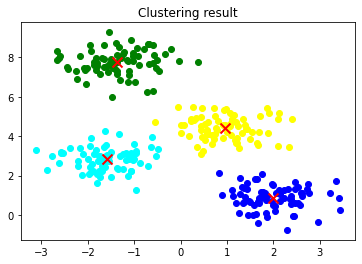


 Cluter center: 
 [[ 1.98258281  0.86771314]
 [ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [-1.58438467  2.83081263]]


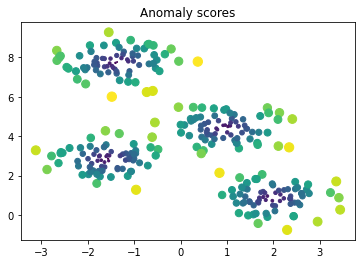

In [17]:
# We first show how clustering method KMeans introduced before can be used for anomaly detection with minor modification

from sklearn.datasets.samples_generator import make_blobs

from sklearn.cluster import KMeans

# Generate an exmaple 2-dimensional datasets containing 4 clusters for a demo

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Create a K-means clustering model with k=4, and k-means++ as the intialization strategy

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)

# Perform clustering by fitting the model with the data

kmeans.fit(X)

# Predict the cluster for each data instance. This step can be combined with the last one by using kmeans.fit_predict(X)

y_pred = kmeans.predict(X)

# Visualize the cluster centers to explore how the clustering result looks like

colors = ['blue', 'yellow', 'green', 'cyan']

for i, color in enumerate(colors):

    plt.scatter(X[y_pred == i, 0], X[y_pred == i, 1], c=color)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', lw=2, c='red', s=100)

plt.title('Clustering result')

plt.show()

print('\n Cluter center: \n', kmeans.cluster_centers_)

# Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers.

# In this way, we could derive the anomaly scores from clustering

X_new=kmeans.transform(X)

scores=X_new.min(axis=1)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=scores, s=50*scores)

plt.title('Anomaly scores')

plt.show()

In [18]:
# Load the data. Orignal data set has been processed (downsampled) to facilitate your data analysis. Anomaly label has been given. Only numerical attributes are used in this data set
#raw_data = pd.read_csv("data/kdd99-0.01.csv")
raw_data = data
print('\n data size: (%d, %d)\n' % raw_data.shape)

raw_data.head()


 data size: (14081, 39)



,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Label
0,0,256,1169,0,0,0,0,0,1,0,...,139,1.0,0.0,0.25,0.04,0.0,0.0,0.0,0.0,1
1,0,248,2129,0,0,0,0,0,1,0,...,255,1.0,0.0,0.04,0.03,0.0,0.0,0.0,0.0,1
2,0,212,1309,0,0,0,0,0,1,0,...,255,1.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0,1
3,0,217,18434,0,0,0,0,0,1,0,...,255,1.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0,1
4,0,290,460,0,0,0,0,0,1,0,...,255,1.0,0.0,0.04,0.05,0.0,0.0,0.0,0.0,1


In [19]:
# Question 1: How can we drop a specific column in the data from processing? 

# Specifying features and target attribute
X = raw_data.drop(['Label'], axis='columns') # Drop specified labels from rows or columns.

X.head()

# The answer of this question is already written as a code.

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38
0,0,256,1169,0,0,0,0,0,1,0,...,4,139,1.0,0.0,0.25,0.04,0.0,0.0,0.0,0.0
1,0,248,2129,0,0,0,0,0,1,0,...,23,255,1.0,0.0,0.04,0.03,0.0,0.0,0.0,0.0
2,0,212,1309,0,0,0,0,0,1,0,...,21,255,1.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0
3,0,217,18434,0,0,0,0,0,1,0,...,41,255,1.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0
4,0,290,460,0,0,0,0,0,1,0,...,23,255,1.0,0.0,0.04,0.05,0.0,0.0,0.0,0.0


In [20]:
# Question 2: How can we scale the numbers to given range for Anomly detection? 

# Transform features by scaling each feature to a given range.
#This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

scaler = preprocessing.MinMaxScaler()
X_data = X.values

X_scaled = scaler.fit_transform(X_data)
X = X_scaled

y = raw_data['Label'].values

# The answer of this question is already written as a code.

In [21]:
# Question 3: What is Anomaly rate? What does it tell us? 

# Anomaly rate. Assuming that the target attribute has '1' for normal instances, and '-1' for anomalies
print('\n Anomaly rate: %f \n' % (-1.0*(y-1).sum()/2.0/X.shape[0]))

""" 
I think Anomaly rate is the difference between the observations expected from the data 
and the observations output by the learned machine.

I think it shows how accurate it is between 
(expected from the data and observations output from the learned machine) the compared observations. 
And the closer the anomaly rate is to zero, the more accurate it can be.

"""


 Anomaly rate: 0.038847 



In [22]:
# Question 4: How can we measure the local deviation of density of a given sample with respect to its neighbors?

# Unsupervised Outlier Detection using Local Outlier Factor (LOF)

# The anomaly score of each sample is called Local Outlier Factor. 

# Create the local outlier factor (LOF). Note here we need to set 'novelty' parameter as 'True' to get LOF scores
detector_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)

# Train the model (Compute the LOF scores)
detector_lof.fit(X)

# Obtain anomaly score (Note that this is not the yes/no prediction as we don't know the threshold)
y_score = detector_lof.decision_function(X)
print(y_score)

[0.19076799 0.50956163 0.5099336  ... 0.40971203 0.33866019 0.53182027]


In [23]:
# Question 5: What is Area Under Curve (AUC) and what information it conveys?

# Evaluate using AUC, the higher, the better
# AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
# Reference: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

auc = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % auc)

# Is AUC high enough? What does the lower value of AUC conveys?

"""
The ROC curve (receiver manipulation characteristic curve) : 
It shows the performance of the classification model at all classification thresholds.

AUC is a kind of measurement of the entire two-dimensional area 
underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1)

AUC measures the aggregation of performance across all possible classification thresholds

AUC lower value means prediction may be wrong. 

It is ambiguous to say that AUC score 0.624886 is high enough. 
However, it is not a very wrong prediction.

"""


 AUC score: 0.624886



In [24]:
# Predict the Yes/No label. The algorithm set a default threshold. But note that this is really data-dependent
y_pred = detector_lof.predict(X)
auc = roc_auc_score(y, y_pred)
print('\n AUC score: %f\n' % auc)


 AUC score: 0.578294



In [25]:
# Create the iForest model
'''
Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings 
required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.
'''
detector_if = IsolationForest()



In [26]:
# Train the model
detector_if.fit(X)

# Obtain anomaly score (Note that this is not the yes/no prediction as we don't know the threshold)
y_score = detector_if.decision_function(X)
print(y_score)

[0.12093642 0.14021275 0.13830064 ... 0.11059019 0.10621644 0.12290125]


In [27]:
# Evaluate using AUC (Area Under Curve)
auc = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % auc)


 AUC score: 0.935595



In [28]:
# Predict the Yes/No label. The algorithm set a default threshold. But note that this is really data-dependent
y_pred = detector_if.predict(X)
print('\n AUC score: %f\n' % roc_auc_score(y, y_pred))


 AUC score: 0.800194



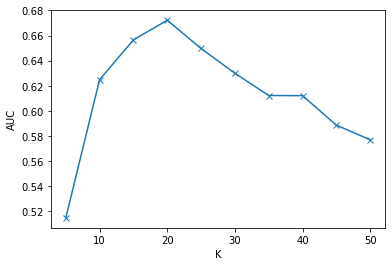

In [33]:
# Task 2.1. Try different values of k ('n_neighbors' parameter) for LOF to identify a good one. 
# Plot the relationship for k changing from 5 to 50 with 5 as the step.

# Please refer to https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

# Computer the auc values for different k
auc_scores = []
for i in range(5, 51, 5):
    detector_lof = LocalOutlierFactor(n_neighbors=i, novelty=True) 
    detector_lof.fit(X)
    y_score = detector_lof.decision_function(X)
    auc = roc_auc_score(y, y_score)
    auc_scores.append(auc)
# Plot the relationship between auc and k
plt.plot(range(5,51,5),auc_scores,marker='x')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

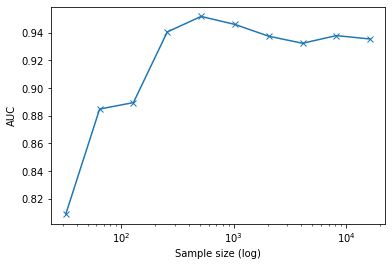

In [35]:
# Task 2.2 Try different sample size ('max_samples' parameter) for iforest to identify a good one. 
# Plot the relationship for the size from 2**5 to 2**14 with an exponential step 2**i.

# Computer the auc values for different sample size
auc_scores = []
sample_sizes = []
for i in range(5, 15):
            sample_sizes.append(2**i)
            detector_if = IsolationForest(max_samples=2**i)
            detector_if.fit(X)
            y_score = detector_if.decision_function(X)
            auc = roc_auc_score(y, y_score)
            auc_scores.append(auc)


# Plot the relationship between auc and sample size
plt.plot(sample_sizes, auc_scores, marker='x')
plt.xscale('log')
plt.xlabel('Sample size (log)')
plt.ylabel('AUC')
plt.show()

In [67]:
# Optional task: Perform anomaly detection with One-Class SVM (https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)

from sklearn.svm import OneClassSVM
def fit(self, X, y=None, score_samples=None, **params):
        """Detects the soft boundary of the set of samples X.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Set of samples, where n_samples is the number of samples and
            n_features is the number of features.
        sample_weight : array-like of shape (n_samples,), default=None
            Per-sample weights. Rescale C per sample. Higher weights
            force the classifier to put more emphasis on these points.
        y : Ignored
            not used, present for API consistency by convention.
        Returns
        -------
        self : object
        Notes
        -----
        If X is not a C-ordered contiguous array it is copied.
        """
        super().fit(X, np.ones(_num_samples(X)),
                    sample_weight=sample_weight, **params)
        self.offset_ = -self._intercept_
        return self

def decision_function(self, X):
        """Signed distance to the separating hyperplane.
        Signed distance is positive for an inlier and negative for an outlier.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        Returns
        -------
        dec : ndarray of shape (n_samples,)
            Returns the decision function of the samples.
        """
        dec = self._decision_function(X).ravel()
        return dec

def score_samples(self, X):
        """Raw scoring function of the samples.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        Returns
        -------
        score_samples : ndarray of shape (n_samples,)
            Returns the (unshifted) scoring function of the samples.
        """
        return self.decision_function(X) + self.offset_

def predict(self, X):
        """Perform classification on samples in X.
        For a one-class model, +1 or -1 is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features) or \
                (n_samples_test, n_samples_train)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Class labels for samples in X.
        """
        y = super().predict(X)
        return np.asarray(y, dtype=np.intp)

X = [[0], [0.44], [0.45], [0.46], [1]]
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)
clf.score_samples(X)



array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])


Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings 
required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.



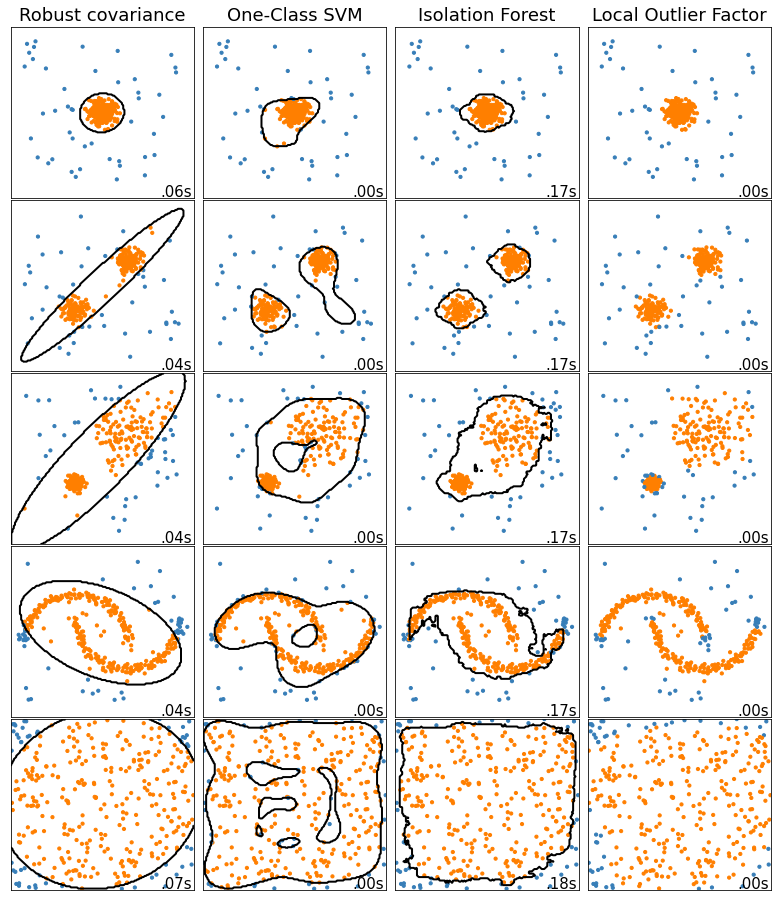

In [12]:
# Putting All-together, Comparing anomaly detection algorithms for outlier detection on toy datasets
# Reference: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [ ]:
'''
This example shows characteristics of different anomaly detection algorithms on 2D datasets. 
Datasets contain one or two modes (regions of high density) to illustrate the ability of algorithms 
to cope with multimodal data.

For each dataset, 15% of samples are generated as random uniform noise. This proportion is the value 
given to the nu parameter of the OneClassSVM and the contamination parameter of the other outlier 
detection algorithms. Decision boundaries between inliers and outliers are displayed in black except 
for Local Outlier Factor (LOF) as it has no predict method to be applied on new data when it is used 
for outlier detection.

The OneClassSVM is known to be sensitive to outliers and thus does not perform very well for outlier 
detection. This estimator is best suited for novelty detection when the training set is not contaminated 
by outliers. That said, outlier detection in high-dimension, or without any assumptions on the distribution 
of the inlying data is very challenging, and a One-class SVM might give useful results in these situations 
depending on the value of its hyperparameters.

EllipticEnvelope (i.e., Robust covariance) assumes the data is Normal or Gaussian (see https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc51.htm) 
and learns an ellipse. It thus degrades when the data is not unimodal. Notice however that this estimator is robust to outliers.

IsolationForest and LocalOutlierFactor seem to perform reasonably well for multi-modal data sets. 
The advantage of LocalOutlierFactor over the other estimators is shown for the third data set, where 
the two modes have different densities. This advantage is explained by the local aspect of LOF, meaning 
that it only compares the score of abnormality of one sample with the scores of its neighbors.

Finally, for the last data set, it is hard to say that one sample is more abnormal than another 
sample as they are uniformly distributed in a hypercube. Except for the OneClassSVM which overfits 
a little, all estimators present decent solutions for this situation. In such a case, it would be 
wise to look more closely at the scores of abnormality of the samples as a good estimator should 
assign similar scores to all the samples.

While these examples give some intuition about the algorithms, this intuition might not apply to 
very high dimensional data.

Finally, note that parameters of the models have been here handpicked but that in practice they 
need to be adjusted. In the absence of labelled data, the problem is completely unsupervised so  
model selection can be a challenge.
'''

abs(mu - np.mean(s) :: 0.003068254604853789


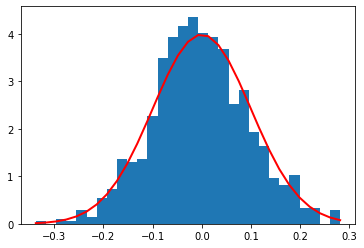

In [20]:
import matplotlib.pyplot as plt
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

absolute = abs(mu - np.mean(s))
print("abs(mu - np.mean(s) :: " + str(absolute))

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()